# Overview
Description.

# Import Modules

## General 

In [1]:
# magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# fix integer division and general modules
import os
from __future__ import division

# numpy
import numpy as np

# scipy~
from scipy.optimize import minimize
from scipy.stats import linregress

# plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
fp = {'family':'serif', 'serif':['Helvetica'], 'size':'20'}
rc('font', **fp)
rc('text', usetex=True)
rc('xtick', labelsize=24) 
rc('ytick', labelsize=24)

## Constitutive Law
Select the constitutive law that is to e fitted. Set `mode` to the provided type of experimental data. Either `'PK1'` for the first Piola-Kirchhoff stresses ("nominal stress") or `'CAU'`for Cauchy stresses ("true stress").

In [15]:
# EDIT =======================================================================
from hlfit.constitutive_models import constitutive_Ogden3_ABQ as cmodel

# what are the stresses obtained from experiment (CAU/PK1)
mode = 'PK1'
# ============================================================================

# constitutive settings
N = cmodel.N

if mode == 'CAU':
    constitutive_model = cmodel.stress_cau
    objective_function = cmodel.objective_function_cau
    jacobian           = cmodel.jacobian_cau
    
if mode == 'PK1':
    constitutive_model = cmodel.stress_pk1
    objective_function = cmodel.objective_function_pk1
    jacobian           = cmodel.jacobian_pk1

Parameter order: [mu1, alpha1, mu2, alpha2, mu3, alpha3]


# Load Experimental Data
Select the configurations that are to be included in the fitting process.

In [16]:
# EDIT: set configurations ================================================
# configs = ['UA']
# configs = ['UA', 'PS']
configs = ['UA', 'PS', 'EB']
# =========================================================================

## Load Experimental Data and Ensure Consistent Strain Sampling

In [17]:
def correct_inflation_strain(eps, h, href=0):
    assert len(h) == len(eps), 'Make sure the height is defined at each strain increment.'
    
    # quadratic polynomial
    p = np.array([  0.00005046,   0.01984404,  13.33554239])
    
    # pixel per millimeter in reference (initial, t=0) plane
    ppm_ref = np.polyval(p, href)
    
    # correction factor for each strain increment
    corr_mult = ppm_ref/np.polyval(p, h)
    
    return corr_mult*(eps + 1) - 1

In [18]:
# here some dummy data for testing
# eps_ua, sig_ua, var_ua = np.loadtxt(os.path.join(os.getcwd(), 'dummy_data/pdms_ua.dat')).T
# eps_ps, sig_ps, var_ps = np.loadtxt(os.path.join(os.getcwd(), 'dummy_data/pdms_ps.dat')).T

# LOAD EXPERIMENTAL DATA ===========================================================================================================
data = list()

# UNIAXIAL ----------
sig, eps = np.loadtxt('/home/rhopf/shared/Sy186/MUA_PK_Eloc.dat').T
# eps, sig = np.loadtxt('/media/rhopf/phd_home/b_zurich_heart/a_experiments/final/M_UA_PDMS_mean_time_5.dat').T

# eps, sig = np.loadtxt('/media/rhopf/phd_home/d_work_various/d_south_africa_valves/a_experiments/analysis/M_PS_DPGLG_sample2B_sp1_test1_final_loading.dat').T

# _, eps, _, _, sig, _ = np.loadtxt('/media/rhopf/phd_home/d_work_various/d_south_africa_valves/a_experiments/analysis/M_UA_DPGLG_sample2A_sp1_test1_final_loading.dat').T

# _, eps, _, _, sig, _ = np.loadtxt('/media/rhopf/phd_home/d_work_various/d_south_africa_valves/a_experiments/analysis/M_UA_PPGA_sample1A_sp1_test1_final_loading.dat').T

# _, eps, _, _, sig, _ = np.loadtxt('/media/rhopf/phd_home/d_work_various/c_daetwyler_elastomers/a_experiments/analysis/M_UA_FM457_0_test6_final_loading.dat').T

# (1) APPEND DATA ---------
data.append([eps, sig])
# ---------------------

# PURE SHEAR -----------+
sig, eps = np.loadtxt('/home/rhopf/shared/Sy186/MPS_PK_Eloc.dat').T
# eps, sig = np.loadtxt('/media/rhopf/phd_home/b_zurich_heart/a_experiments/final/M_PS_PDMS_mean_time_5.dat').T

# _, eps, _, _, sig, _ = np.loadtxt('/media/rhopf/phd_home/d_work_various/d_south_africa_valves/a_experiments/analysis/M_PS_DPGLG_sample2B_sp1_test1_final_loading.dat').T

# _, eps, _, _, sig, _ = np.loadtxt('/media/rhopf/phd_home/d_work_various/d_south_africa_valves/a_experiments/analysis/M_PS_PPGA_sample1B_sp2_test1_final_loading.dat').T

# _, eps, _, _, sig, _ = np.loadtxt('/media/rhopf/phd_home/d_work_various/c_daetwyler_elastomers/a_experiments/analysis/M_PS_FM457_0_test3_final_loading.dat').T

# (2) APPEND DATA ---------
data.append([eps, sig])
# ---------------------

# # EQUI-BIAXIAL-----------
sig, eps = np.loadtxt('/home/rhopf/shared/Sy186/MBA_PK_Eloc.dat').T
# eps, sig, _, _, apex = np.loadtxt('/media/rhopf/phd_home/b_zurich_heart/a_experiments/M_IF_PDMS_run3/results/Monotonic_Loading.txt').T
# eps = correct_inflation_strain(eps, apex, apex[0])

# (3) APPEND DATA ---------
data.append([eps, sig])
# ---------------------
# ===================================================================================================================================

# samples per percent strain
samples_per_strain = 2

# interpolate strains and stresses and write dict
eps_max = list()
eps_exp = dict()
sig_exp = dict()
assert len(configs) == len(data), 'Number of configs doesn\'t match the number of loaded data sets!'
for i, (data_i, conf) in enumerate(zip(data, configs)):
    eps, sig = data_i
    eps_ip = np.arange(0, np.max(eps), 0.01/samples_per_strain)
    sig_ip = np.interp(eps_ip, eps, sig)
    
    # write write dict
    eps_exp[conf] = eps_ip
    sig_exp[conf] = sig_ip
    
    # highest strain
    eps_max.append(eps_ip.max())
    
# identify highest strains
eps_exp['MAX'] = np.arange(0, np.max(eps_max), 0.01/samples_per_strain)

# Constraints

## Bounds

## Equations

#Optimize

Use either **(A)** in order to perform a **single** run using a random set of starting data. If no unique optimum is guaranteed, use **(B)** to run the optimization several times: the best of the set can be found afterwards.

##Settings

In [19]:
# weight vector (don't edit)
d  = ['UA', 'PS', 'EB']
w  = [0, 0, 0]
ni = [np.sum(eps_exp[conf]) for conf in configs]
n  = np.sum(ni)

for nii, conf in zip(ni, configs):
    for i, confi in enumerate(d):
        if conf == confi:
            w[i] = nii/n

##(A) Single Loop

In [24]:
# starting value
C0 = np.random.randn(N)

# optimize
C_opt = minimize(objective_function, C0, jac=jacobian,
                 args=(eps_exp, sig_exp, configs, w),
                 method='L-BFGS-B', options={'disp':True, 'maxiter':10000})

# store in global var (ugly hack for consistency between 1 and multi parameter models)
if len(C_opt.x)==1:
    cs_s = [[C_opt.x]]
else:
    cs_s = [C_opt.x]
    
print C_opt.fun
print C_opt.x

0.00906892737826
[ 0.36574874 -1.88768411 -0.85275141 -1.15380386  0.80797483  0.14692928]


##(B) Multi Loop

##Plot

[ 0.36574874 -1.88768411 -0.85275141 -1.15380386  0.80797483  0.14692928]


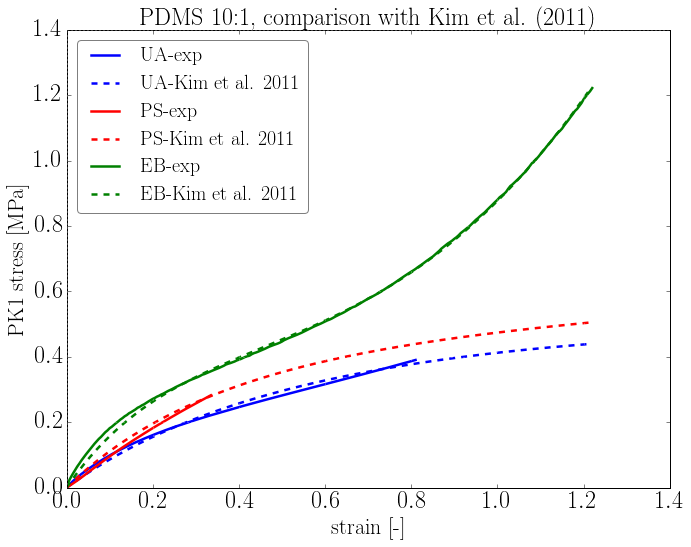

In [25]:
# data for plots

sig_sim = dict()
for conf in configs:
    sig_sim[conf] = constitutive_model(C_opt.x, eps_exp['MAX'], config=conf)

# show data
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111)
c   = ['b', 'r', 'g']
c   = iter(c)

for conf in configs:
    color = c.next()
    ax.plot(eps_exp[conf], sig_exp[conf], color=color, lw=2.5, label=conf + '-exp')
    ax.plot(eps_exp['MAX'], sig_sim[conf], color=color, linestyle='--', lw=2.5, label=conf + '-Kim et al. 2011')

leg = ax.legend(loc=2, prop={'size':20}, fancybox=True)
leg.get_frame().set_alpha(0.5)
ax.set_title('PDMS 10:1, comparison with Kim et al. (2011)')
ax.grid(color='1.0')
ax.set_xlabel('strain [-]')
if mode == 'PK1':
    ax.set_ylabel('PK1 stress [MPa]')
if mode == 'CAU':
    ax.set_ylabel('Cauchy stress [MPa]')
ax.yaxis.label.set_fontsize(22)
ax.xaxis.label.set_fontsize(22)
ax.title.set_fontsize(24)
# ax.set_ylim([0, 7])
ax.tick_params(labelsize=24, labelcolor='k')
# fig.savefig('/home/rhopf/Dropbox/x_publications/journal/polymer_mechanics/pdms_properties-hopf/graphics/compare_kim_pdms10.pdf',
#               transparent=True, bbox_inches='tight', pad_inches=0)
fig.tight_layout()

# print parameters
print C_opt.x

###Save Files

In [28]:
# np.savetxt('/home/rhopf/Dropbox/b_zurich_heart/b_simulations/pdms_experimental/material_models/ogden3_t5_set10.txt', np.r_[C_opt.x, [0, 0, 0]][None], delimiter=',')

In [29]:
# save stress strain
# np.savetxt('/home/rhopf/Dropbox/b_zurich_heart/b_simulations/pdms_experimental/output/UA_eps_sig_NH_t5_set1.dat', np.c_[eps_ua, sig_ua_sim])

In [30]:
np.savetxt('/home/rhopf/temp/mail/exp_uniaxial.dat', np.c_[eps_exp['UA'], sig_exp['UA']])
np.savetxt('/home/rhopf/temp/mail/exp_pureshear.dat', np.c_[eps_exp['PS'], sig_exp['PS']])
np.savetxt('/home/rhopf/temp/mail/exp_equibiaxial.dat', np.c_[eps_exp['EB'], sig_exp['EB']])

# Plot any Data

[ -6.60490916e+02  -1.62219054e-03  -5.83677230e-04  -7.56996041e+00]


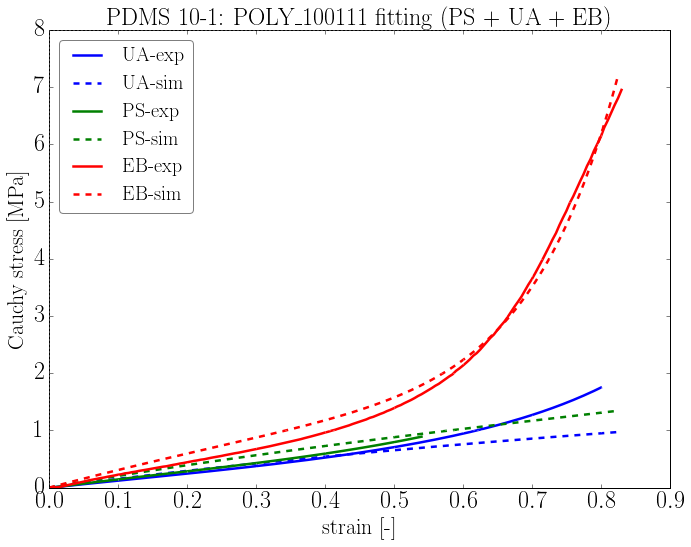

In [16]:
# data for plots
C_opt.x = 
sig_sim = dict()
for conf in configs:
    sig_sim[conf] = constitutive_model(C_opt.x, eps_exp['MAX'], config=conf)

# show data
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111)
c   = ax._get_lines.color_cycle

for conf in configs:
    color = c.next()
    ax.plot(eps_exp[conf], sig_exp[conf], color=color, lw=2.5, label=conf + '-exp')
    ax.plot(eps_exp['MAX'], sig_sim[conf], color=color, linestyle='--', lw=2.5, label=conf + '-sim')

leg = ax.legend(loc=2, prop={'size':20}, fancybox=True)
leg.get_frame().set_alpha(0.5)
ax.set_title('PDMS 10-1: POLY\_100111 fitting (PS + UA + EB)')
ax.grid(color='1.0')
ax.set_xlabel('strain [-]')
if mode == 'PK1':
    ax.set_ylabel('PK1 stress [MPa]')
if mode == 'CAU':
    ax.set_ylabel('Cauchy stress [MPa]')
ax.yaxis.label.set_fontsize(22)
ax.xaxis.label.set_fontsize(22)
ax.title.set_fontsize(24)
# ax.set_ylim([0, 7])
ax.tick_params(labelsize=24, labelcolor='k')
# fig.savefig('/home/rhopf/Dropbox/b_zurich_heart/b_simulations/pdms_experimental/material_models/pdms_10-1_poly_100111.pdf',
#               transparent=True, bbox_inches='tight', pad_inches=0)
fig.tight_layout()

# print parameters
print C_opt.x